# Document Image Classification - Exploratory Data Analysis (EDA)

This notebook performs a thorough exploratory data analysis on the document image dataset.

**Analysis Goals:**
1. Understand the basic structure and class distribution of the dataset.
2. Analyze the visual characteristics of the images (dimensions, aspect ratio, channels).
3. Visualize image samples for each class to gain qualitative insights.
4. Explore suitable data augmentation techniques for document images.
5. Analyze inter-class similarity to identify potentially confusing classes for the model.

## 1. Setup and Library Imports

In [45]:
import project_setup
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
from PIL import Image
from pathlib import Path
from collections import Counter
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl

# Add project root to path for imports
sys.path.append('..')
import project_setup
# Set the font family to NanumGothic
mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False

# Set the default style for seaborn plots
sns.set_theme(style="whitegrid", font="NanumGothic", font_scale=1.1, rc={'axes.unicode_minus': False}
)
# Visualization styles
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

# Set a random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("✅ Libraries imported successfully")

✅ Project environment initialized. Root: /home/wb2x/projects/ml-projects/document-classifier
✅ Libraries imported successfully


## 2. Dataset Path and Basic Info

In [46]:
DATASET_PATH = project_setup.PROJECT_ROOT / "data" / "raw"
TRAIN_CSV = DATASET_PATH / "metadata" / "train.csv"
META_CSV = DATASET_PATH / "metadata" / "meta.csv"
SAMPLE_SUBMISSION_CSV = project_setup.PROJECT_ROOT / "data" / "dataset" / "sample_submission.csv"


dataset_path = Path(DATASET_PATH)
train_images_path = dataset_path / "train"
test_images_path = dataset_path / "test"
train_images_path = DATASET_PATH / "train"

print(f"Dataset path: {DATASET_PATH} - {'✅' if DATASET_PATH.exists() else '❌'}")
print(f"Train images: {train_images_path} - {'✅' if train_images_path.exists() else '❌'}")
print(f"Test images: {test_images_path} - {'✅' if test_images_path.exists() else '❌'}")
print(f"Train CSV: {TRAIN_CSV} - {'✅' if TRAIN_CSV.exists() else '❌'}")
print(f"Meta CSV: {META_CSV} - {'✅' if META_CSV.exists() else '❌'}")



Dataset path: /home/wb2x/projects/ml-projects/document-classifier/data/raw - ✅
Train images: /home/wb2x/projects/ml-projects/document-classifier/data/raw/train - ✅
Test images: /home/wb2x/projects/ml-projects/document-classifier/data/raw/test - ✅
Train CSV: /home/wb2x/projects/ml-projects/document-classifier/data/raw/metadata/train.csv - ✅
Meta CSV: /home/wb2x/projects/ml-projects/document-classifier/data/raw/metadata/meta.csv - ✅


In [47]:
# Load CSV files
train_df = pd.read_csv(TRAIN_CSV)
meta_df = pd.read_csv(META_CSV)

print("📊 Train CSV Info:")
print(f"Shape: {train_df.shape}")
print(f"Columns: {train_df.columns.tolist()}")
print("\nFirst 5 rows:")
display(train_df.head())

print("\n📋 Meta CSV Info:")
print(f"Shape: {meta_df.shape}")
print(f"Columns: {meta_df.columns.tolist()}")
print("\nFirst 5 rows:")
display(meta_df.head())

📊 Train CSV Info:
Shape: (1570, 2)
Columns: ['ID', 'target']

First 5 rows:


ID  target
0  002f99746285dfdd.jpg      16
1  008ccd231e1fea5d.jpg      10
2  008f5911bfda7695.jpg      10
3  009235e4c9c07af5.jpg       4
4  00b2f44967580c74.jpg      16


📋 Meta CSV Info:
Shape: (17, 2)
Columns: ['target', 'class_name']

First 5 rows:


target                                         class_name
0       0                                     account_number
1       1  application_for_payment_of_pregnancy_medical_e...
2       2                                      car_dashboard
3       3            confirmation_of_admission_and_discharge
4       4                                          diagnosis

In [48]:
# Create class mapping and add class names to train_df
target_to_class = dict(zip(meta_df['target'], meta_df['class_name']))
class_to_target = dict(zip(meta_df['class_name'], meta_df['target']))

# Add class names to train dataframe
train_df['class_name'] = train_df['target'].map(target_to_class)

print(f"✅ Found {len(target_to_class)} classes")
print(f"Target range: {min(target_to_class.keys())} to {max(target_to_class.keys())}")

✅ Found 17 classes
Target range: 0 to 16


## 3. Class Distribution Analysis

In [49]:
# Analyze class distribution
class_counts = train_df['target'].value_counts().sort_index()
class_name_counts = train_df['class_name'].value_counts()

print("📊 Class Distribution:")
for target, count in class_counts.items():
    class_name = target_to_class[target]
    percentage = (count / len(train_df)) * 100
    print(f"Target {target:2d} ({class_name[:30]:30s}): {count:4d} samples ({percentage:5.1f}%)")

📊 Class Distribution:
Target  0 (account_number                ):  100 samples (  6.4%)
Target  1 (application_for_payment_of_pre):   46 samples (  2.9%)
Target  2 (car_dashboard                 ):  100 samples (  6.4%)
Target  3 (confirmation_of_admission_and_):  100 samples (  6.4%)
Target  4 (diagnosis                     ):  100 samples (  6.4%)
Target  5 (driver_lisence                ):  100 samples (  6.4%)
Target  6 (medical_bill_receipts         ):  100 samples (  6.4%)
Target  7 (medical_outpatient_certificate):  100 samples (  6.4%)
Target  8 (national_id_card              ):  100 samples (  6.4%)
Target  9 (passport                      ):  100 samples (  6.4%)
Target 10 (payment_confirmation          ):  100 samples (  6.4%)
Target 11 (pharmaceutical_receipt        ):  100 samples (  6.4%)
Target 12 (prescription                  ):  100 samples (  6.4%)
Target 13 (resume                        ):   74 samples (  4.7%)
Target 14 (statement_of_opinion          ):   50 sampl

/tmp/ipykernel_500737/3577347268.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis', ax=ax1)
/tmp/ipykernel_500737/3577347268.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_classes.values, y=top_classes.index, palette='viridis', ax=ax2)


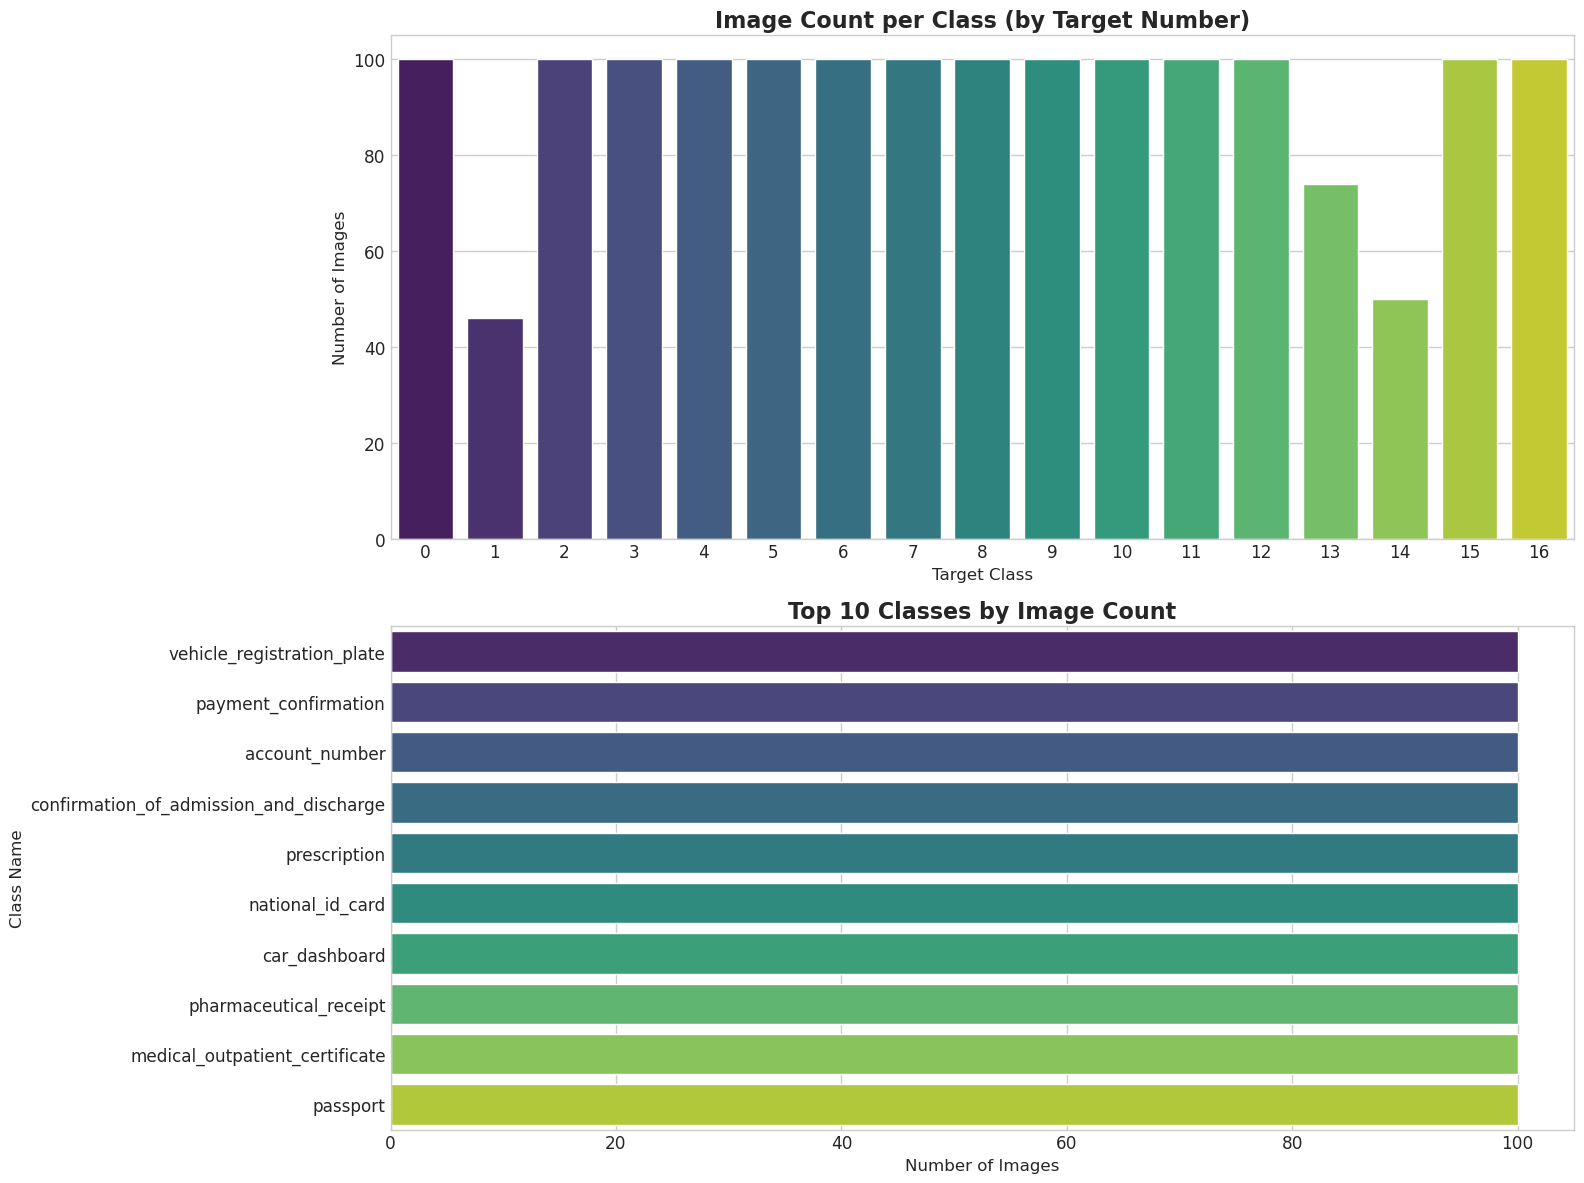

In [50]:
# Visualize class distribution
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# By target number
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis', ax=ax1)
ax1.set_title('Image Count per Class (by Target Number)', fontsize=16, fontweight='bold')
ax1.set_xlabel('Target Class', fontsize=12)
ax1.set_ylabel('Number of Images', fontsize=12)

# By class name (top 10 for readability)
top_classes = class_name_counts.head(10)
sns.barplot(x=top_classes.values, y=top_classes.index, palette='viridis', ax=ax2)
ax2.set_title('Top 10 Classes by Image Count', fontsize=16, fontweight='bold')
ax2.set_xlabel('Number of Images', fontsize=12)
ax2.set_ylabel('Class Name', fontsize=12)

plt.tight_layout()
plt.show()

In [51]:
# Class imbalance analysis
total_images = len(train_df)
min_count = class_counts.min()
max_count = class_counts.max()
imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

print(f"\n📈 Class Imbalance Analysis:")
print(f"Total training images: {total_images:,}")
print(f"Most frequent class: {class_counts.max():,} samples")
print(f"Least frequent class: {class_counts.min():,} samples")


📈 Class Imbalance Analysis:
Total training images: 1,570
Most frequent class: 100 samples
Least frequent class: 46 samples


In [52]:
# Class imbalance analysis
total_images = len(train_df)
min_count = class_counts.min()
max_count = class_counts.max()
imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

print(f"\n📈 Class Imbalance Analysis:")
print(f"Total training images: {total_images:,}")
print(f"Most frequent class: {class_counts.max():,} samples")
print(f"Least frequent class: {class_counts.min():,} samples")
print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}")
print(f"Standard deviation: {class_counts.std():.2f}")

# Classes with very few samples (potential issues)
threshold = total_images * 0.01  # Less than 1% of total data
# Ensure class_counts is a Series of integers, and threshold is a float
rare_classes = class_counts[class_counts.astype(float) < float(threshold)]
if len(rare_classes) > 0:
    print(f"\n⚠️  Classes with < 1% of data ({threshold:.0f} samples):")
    for target, count in rare_classes.items():
        print(f"  Target {target} ({target_to_class[target][:40]}): {count} samples")


📈 Class Imbalance Analysis:
Total training images: 1,570
Most frequent class: 100 samples
Least frequent class: 46 samples
Imbalance ratio (max/min): 2.17
Standard deviation: 17.85


## 4. Image Feature Analysis

We analyze the physical properties of the images like dimensions, aspect ratios, and color channels.

In [53]:
# Function to analyze image properties
def analyze_image_stats(image_paths, sample_size=1000):
    """Analyze image statistics from a list of image paths"""
    if len(image_paths) > sample_size:
        sampled_paths = random.sample(image_paths, sample_size)
        print(f"📊 Analyzing {sample_size} randomly sampled images out of {len(image_paths)} total")
    else:
        sampled_paths = image_paths
        print(f"📊 Analyzing all {len(image_paths)} images")
    
    img_stats = []
    failed_count = 0
    
    for img_file in tqdm(sampled_paths, desc="Analyzing images"):
        img_path = train_images_path / img_file
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                img_stats.append({
                    'filename': img_file,
                    'width': width,
                    'height': height,
                    'aspect_ratio': width / height if height > 0 else 0,
                    'area': width * height,
                    'mode': img.mode
                })
        except Exception as e:
            failed_count += 1
            if failed_count <= 5:  # Show first 5 errors
                print(f"❌ Error processing {img_file}: {e}")
    
    if failed_count > 0:
        print(f"⚠️  Failed to process {failed_count} images")
    
    return pd.DataFrame(img_stats)

# Get list of all training images
all_train_images = train_df['ID'].tolist()
print(f"Total training images in CSV: {len(all_train_images)}")

# Check how many actually exist
existing_images = []
missing_count = 0
for img_file in all_train_images[:100]:  # Check first 100
    if (train_images_path / img_file).exists():
        existing_images.append(img_file)
    else:
        missing_count += 1

print(f"Sample check - Found: {len(existing_images)}, Missing: {missing_count} (out of first 100)")

Total training images in CSV: 1570
Sample check - Found: 100, Missing: 0 (out of first 100)


In [54]:
# Analyze image statistics
img_stats_df = analyze_image_stats(all_train_images, sample_size=1500)

if not img_stats_df.empty:
    print("\n📊 Image Statistics Summary:")
    display(img_stats_df.describe())
    
    print(f"\n🎨 Image Modes:")
    mode_counts = img_stats_df['mode'].value_counts()
    for mode, count in mode_counts.items():
        percentage = (count / len(img_stats_df)) * 100
        print(f"  {mode}: {count} images ({percentage:.1f}%)")

📊 Analyzing 1500 randomly sampled images out of 1570 total


Analyzing images:   0%|          | 0/1500 [00:00<?, ?it/s]


📊 Image Statistics Summary:


width       height  aspect_ratio           area
count  1500.000000  1500.000000   1500.000000    1500.000000
mean    496.953333   538.790000      0.967279  261780.574000
std      79.014142    75.810246      0.321334     120.246752
min     384.000000   348.000000      0.563050  261184.000000
25%     443.000000   443.000000      0.749577  261813.000000
50%     443.000000   591.000000      0.749577  261813.000000
75%     591.000000   591.000000      1.334086  261813.000000
max     753.000000   682.000000      2.163793  262144.000000


🎨 Image Modes:
  RGB: 1500 images (100.0%)


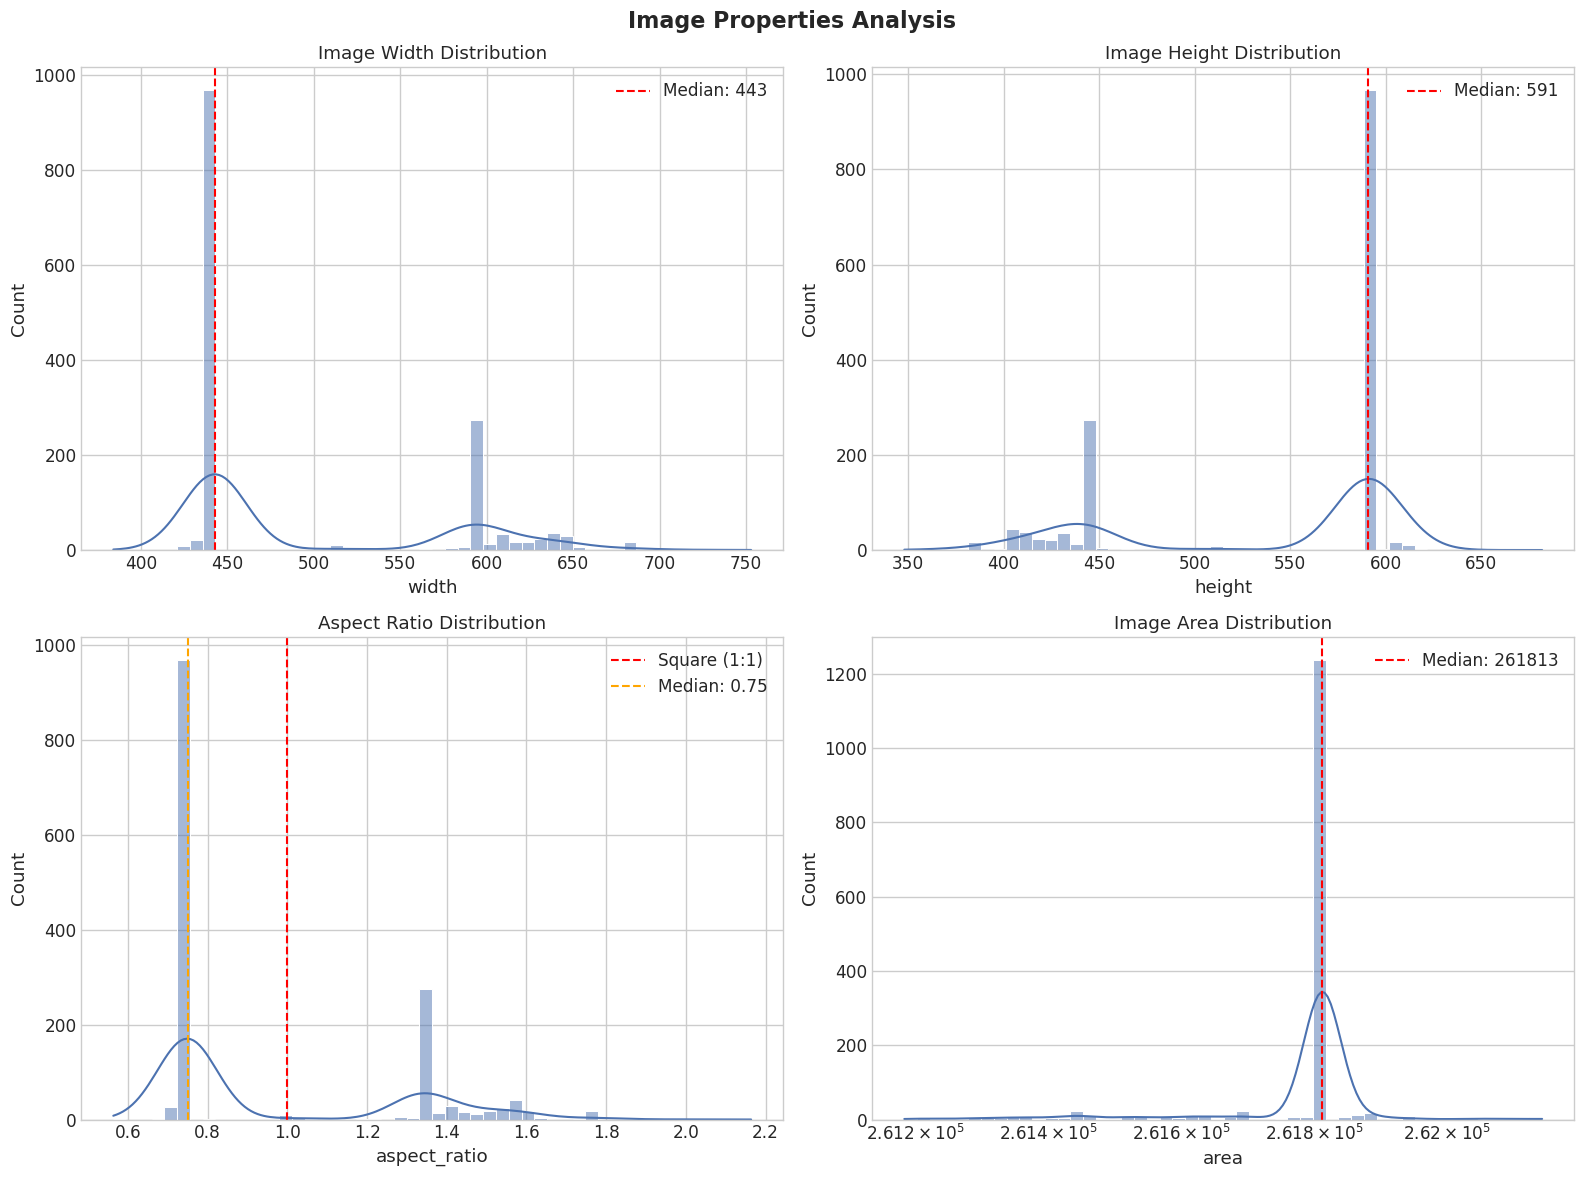

In [55]:
# Visualize image dimensions and properties
if not img_stats_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Width distribution
    sns.histplot(data=img_stats_df, x='width', bins=50, ax=axes[0,0], kde=True)
    axes[0,0].set_title('Image Width Distribution')
    axes[0,0].axvline(img_stats_df['width'].median(), color='red', linestyle='--', label=f'Median: {img_stats_df["width"].median():.0f}')
    axes[0,0].legend()
    
    # Height distribution
    sns.histplot(data=img_stats_df, x='height', bins=50, ax=axes[0,1], kde=True)
    axes[0,1].set_title('Image Height Distribution')
    axes[0,1].axvline(img_stats_df['height'].median(), color='red', linestyle='--', label=f'Median: {img_stats_df["height"].median():.0f}')
    axes[0,1].legend()
    
    # Aspect ratio distribution
    sns.histplot(data=img_stats_df, x='aspect_ratio', bins=50, ax=axes[1,0], kde=True)
    axes[1,0].set_title('Aspect Ratio Distribution')
    axes[1,0].axvline(1.0, color='red', linestyle='--', label='Square (1:1)')
    axes[1,0].axvline(img_stats_df['aspect_ratio'].median(), color='orange', linestyle='--', label=f'Median: {img_stats_df["aspect_ratio"].median():.2f}')
    axes[1,0].legend()
    
    # Area distribution (log scale)
    sns.histplot(data=img_stats_df, x='area', bins=50, ax=axes[1,1], kde=True)
    axes[1,1].set_title('Image Area Distribution')
    axes[1,1].set_xscale('log')
    axes[1,1].axvline(img_stats_df['area'].median(), color='red', linestyle='--', label=f'Median: {img_stats_df["area"].median():.0f}')
    axes[1,1].legend()
    
    plt.suptitle('Image Properties Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [56]:
# Detailed statistics
if not img_stats_df.empty:
    print("📏 Detailed Image Statistics:")
    print(f"Width  - Min: {img_stats_df['width'].min():4.0f}, Max: {img_stats_df['width'].max():4.0f}, Mean: {img_stats_df['width'].mean():6.1f}")
    print(f"Height - Min: {img_stats_df['height'].min():4.0f}, Max: {img_stats_df['height'].max():4.0f}, Mean: {img_stats_df['height'].mean():6.1f}")
    print(f"Aspect - Min: {img_stats_df['aspect_ratio'].min():4.2f}, Max: {img_stats_df['aspect_ratio'].max():4.2f}, Mean: {img_stats_df['aspect_ratio'].mean():6.2f}")
    
    # Common resolutions
    resolution_counts = img_stats_df.groupby(['width', 'height']).size().sort_values(ascending=False).head(10)
    print(f"\n📐 Top 10 Most Common Resolutions:")
    for (w, h), count in resolution_counts.items():
        percentage = (count / len(img_stats_df)) * 100
        print(f"  {w:4.0f} x {h:4.0f}: {count:3d} images ({percentage:4.1f}%)")

📏 Detailed Image Statistics:
Width  - Min:  384, Max:  753, Mean:  497.0
Height - Min:  348, Max:  682, Mean:  538.8
Aspect - Min: 0.56, Max: 2.16, Mean:   0.97

📐 Top 10 Most Common Resolutions:
   443 x  591: 963 images (64.2%)
   591 x  443: 267 images (17.8%)
   682 x  384:  18 images ( 1.2%)
   608 x  430:  10 images ( 0.7%)
   643 x  407:   8 images ( 0.5%)
   641 x  408:   7 images ( 0.5%)
   512 x  512:   6 images ( 0.4%)
   626 x  418:   5 images ( 0.3%)
   638 x  410:   5 images ( 0.3%)
   637 x  411:   5 images ( 0.3%)


## 5. Visualizing Class Samples
Let's look at some examples from each class to understand their visual content.

In [57]:
def visualize_class_samples(class_target, num_samples=5, figsize=(20, 4)):
    """Visualize sample images for a specific class"""
    class_name = target_to_class[class_target]
    class_images = train_df[train_df['target'] == class_target]['ID'].tolist()
    
    if not class_images:
        print(f"No images found for class {class_target}")
        return
    
    # Sample random images
    sample_images = random.sample(class_images, min(num_samples, len(class_images)))
    
    fig, axes = plt.subplots(1, len(sample_images), figsize=figsize)
    if len(sample_images) == 1:
        axes = [axes]
    
    for ax, img_file in zip(axes, sample_images):
        img_path = train_images_path / img_file
        try:
            img = Image.open(img_path)
            ax.imshow(img)
            ax.set_title(f"{img.width}x{img.height}\n{img_file[:15]}...")
            ax.axis('off')
        except Exception as e:
            ax.set_title(f"Error loading\n{img_file[:15]}...")
            ax.text(0.5, 0.5, "Image not found", ha='center', va='center', transform=ax.transAxes)
            ax.axis('off')
    
    # Add class info
    class_count = len(class_images)
    fig.suptitle(f'Target {class_target}: {class_name}\n({class_count} total images)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

🖼️  Visualizing sample images for each class...


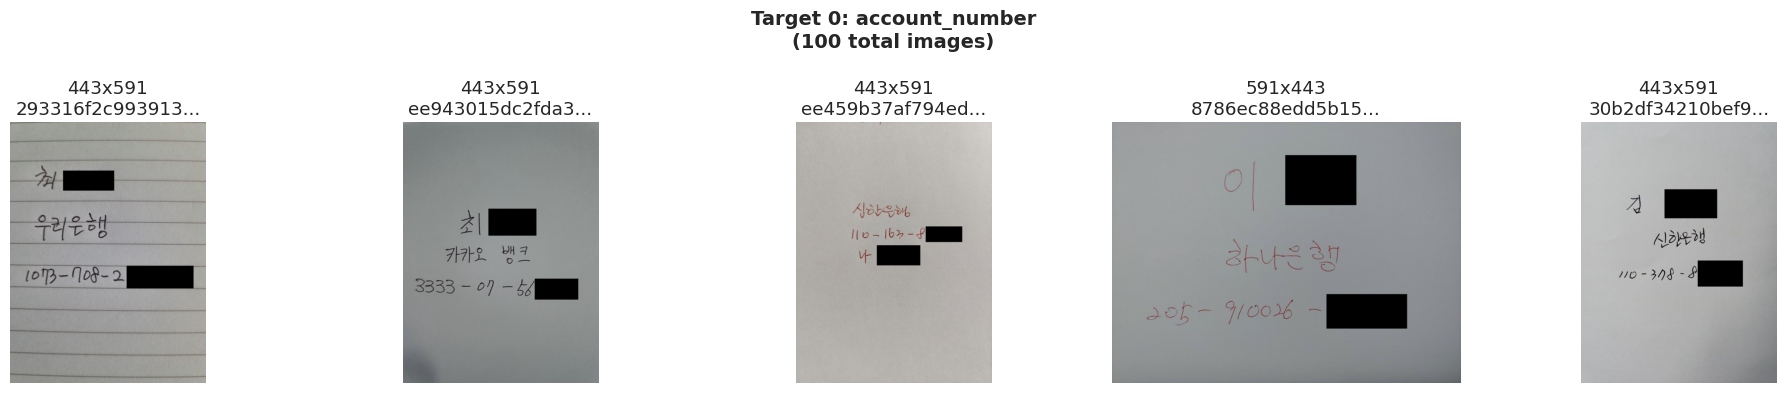

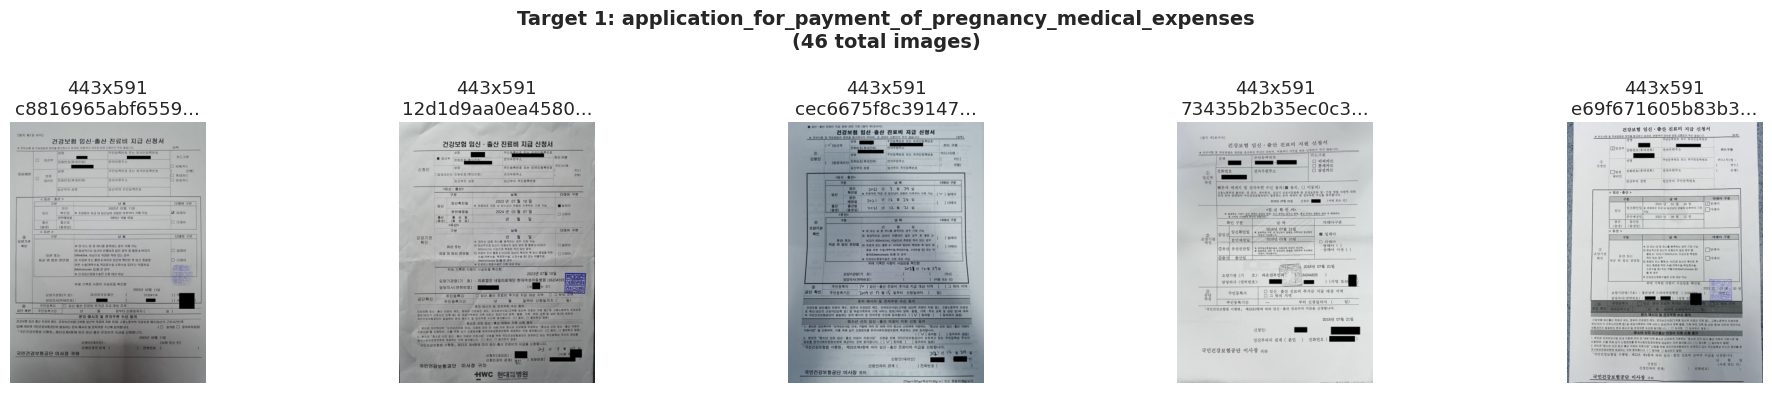

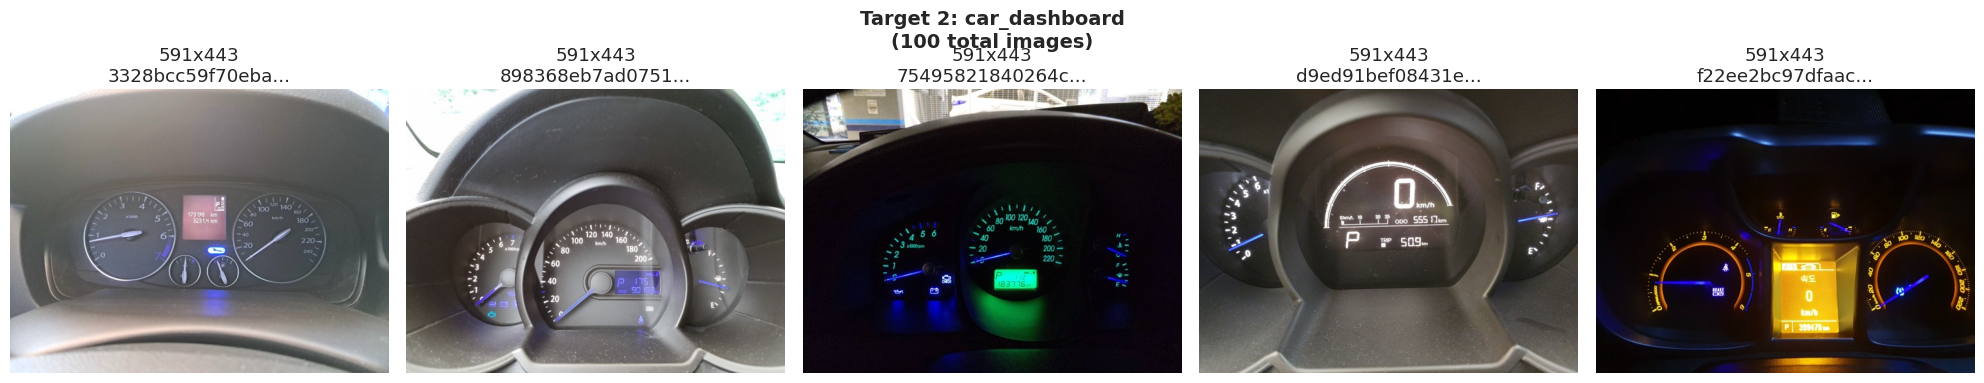

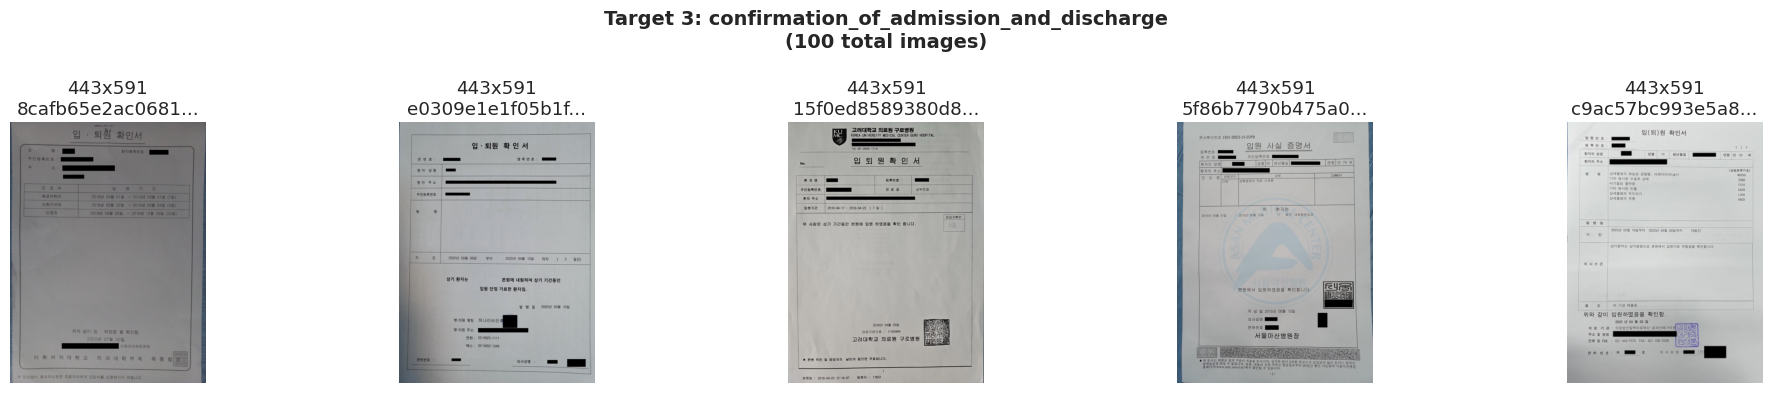

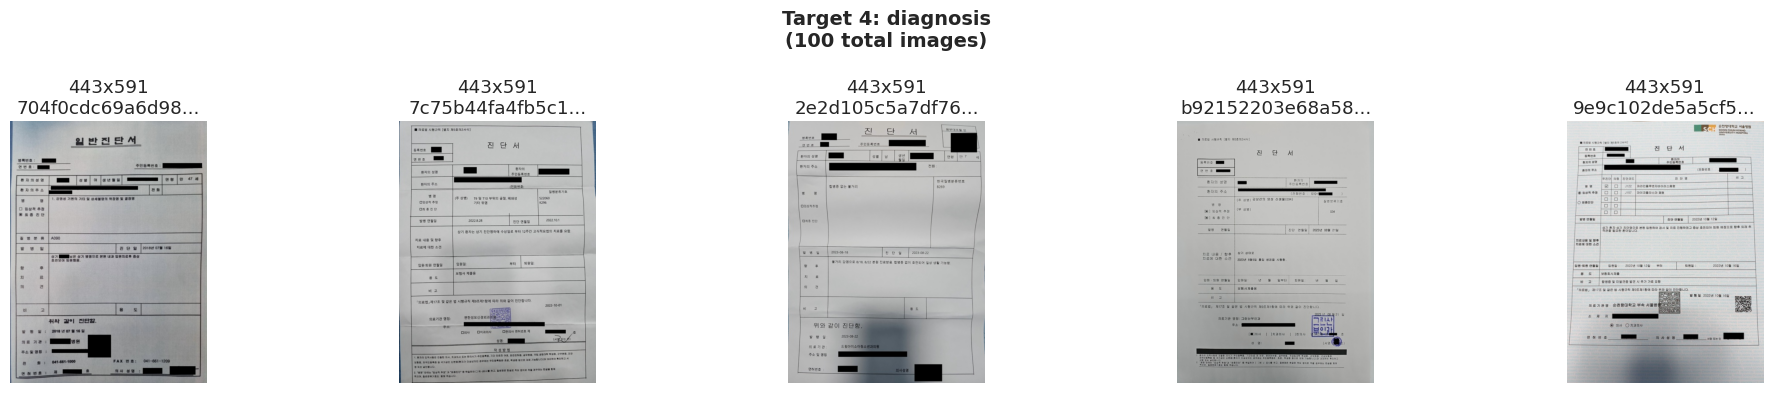

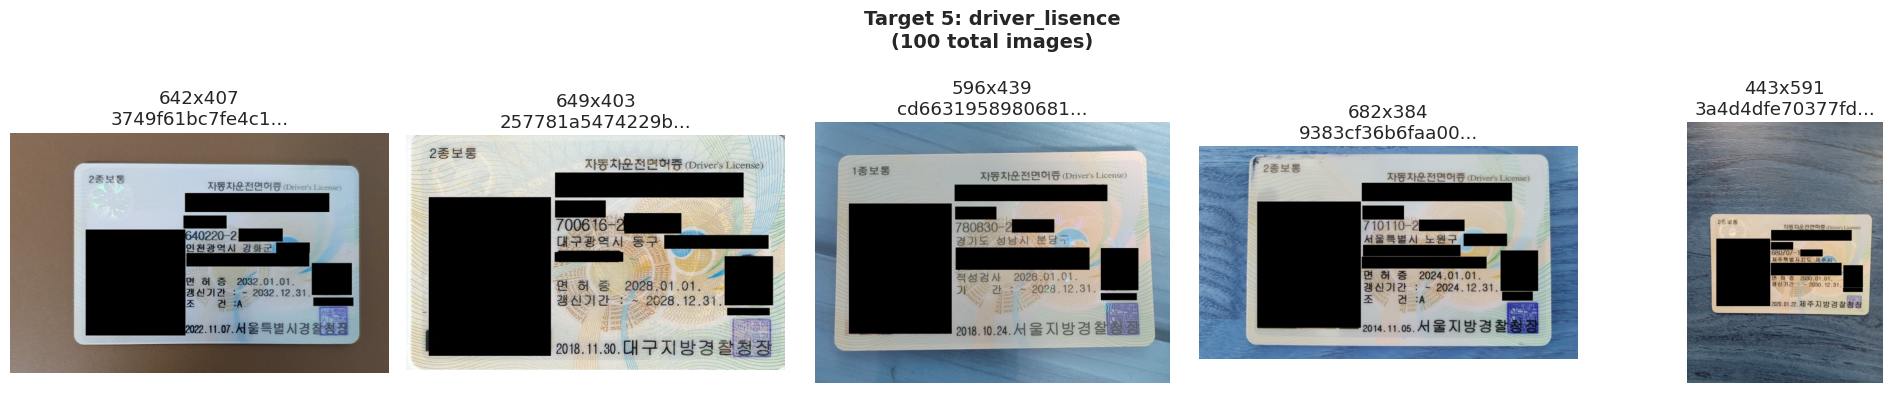

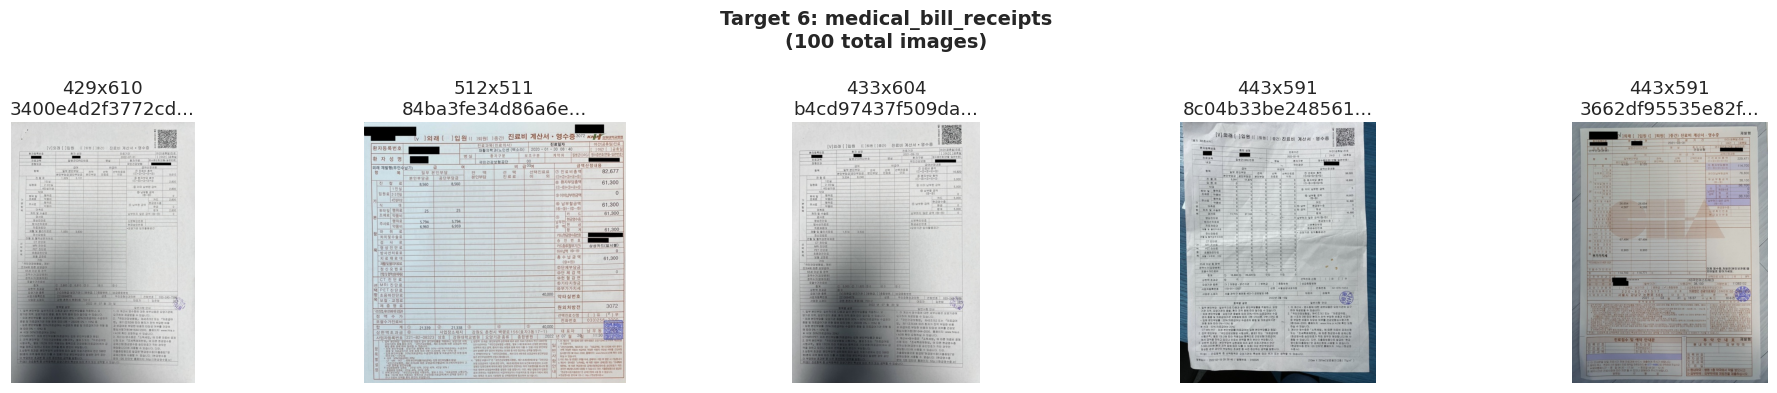

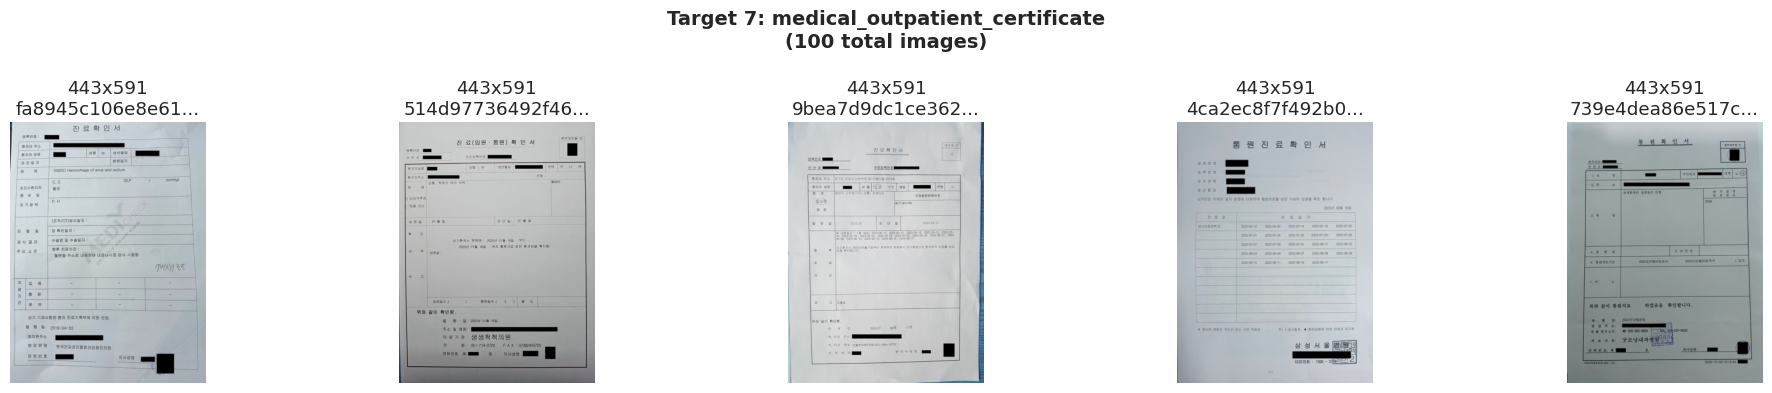

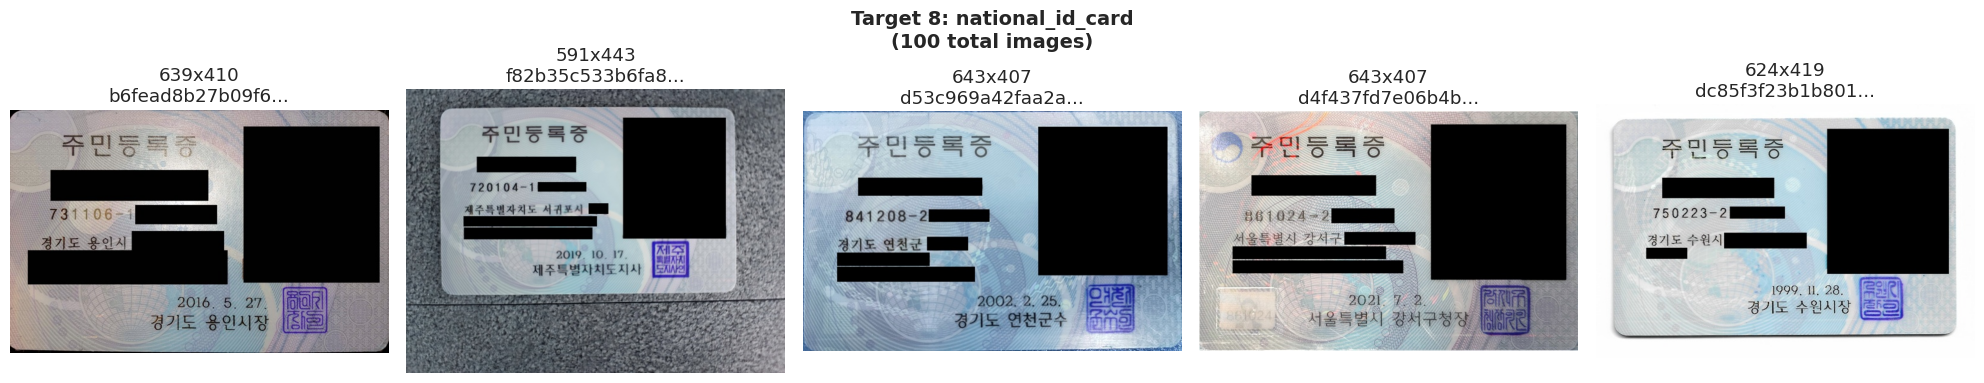

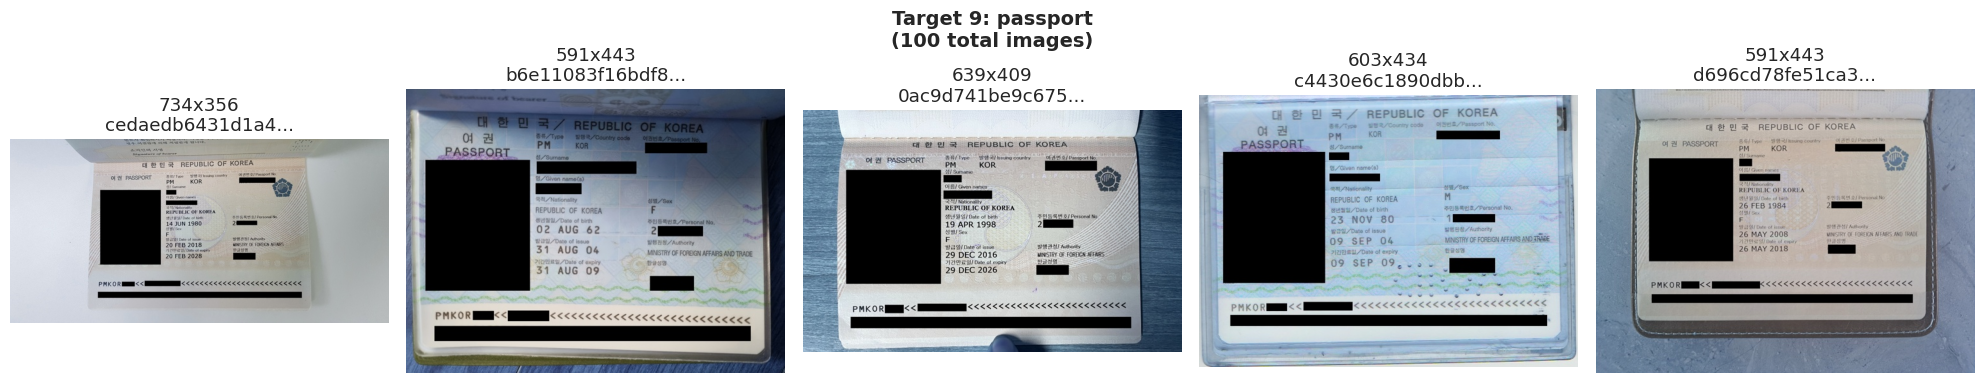

In [58]:
# Visualize samples for each class (showing first 10 classes)
print("🖼️  Visualizing sample images for each class...")
classes_to_show = sorted(train_df['target'].unique())[:10]  # First 10 classes

for class_target in classes_to_show:
    visualize_class_samples(class_target, num_samples=5)


🖼️  Visualizing remaining 7 classes...


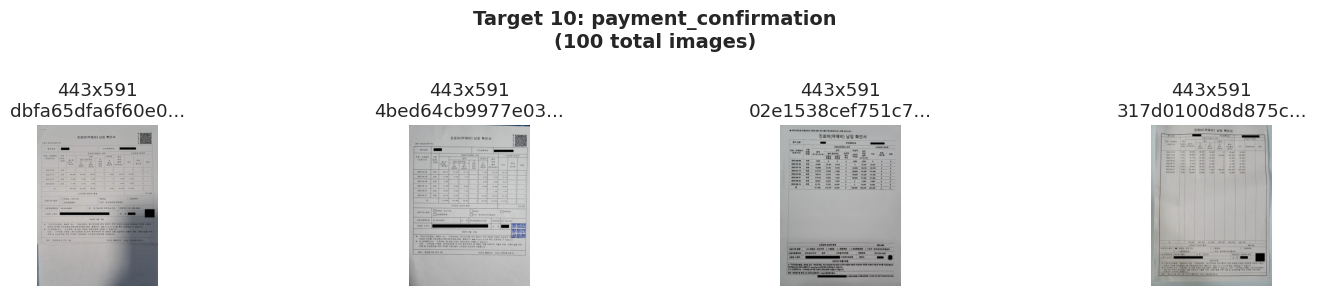

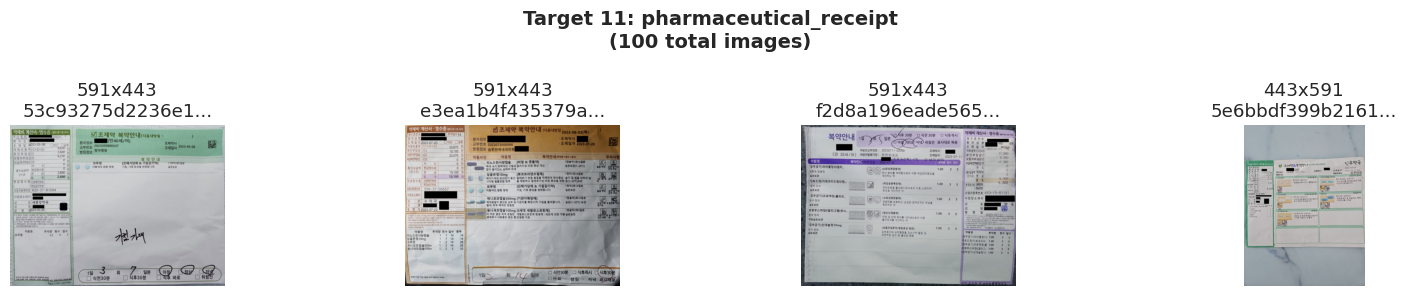

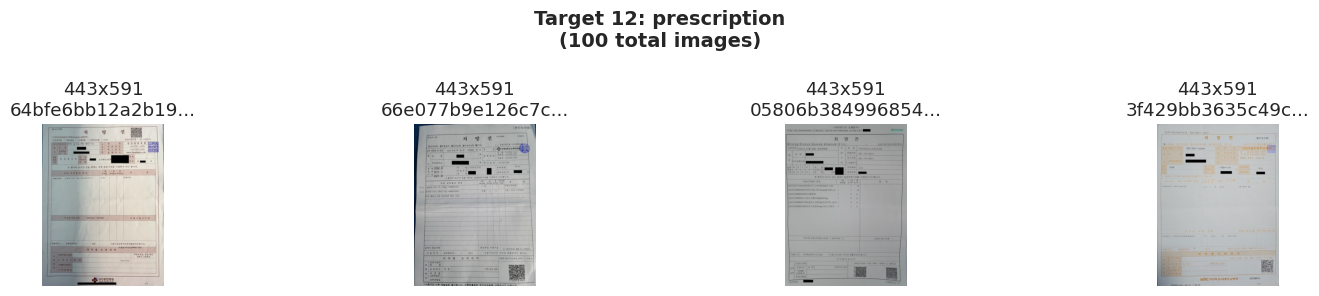

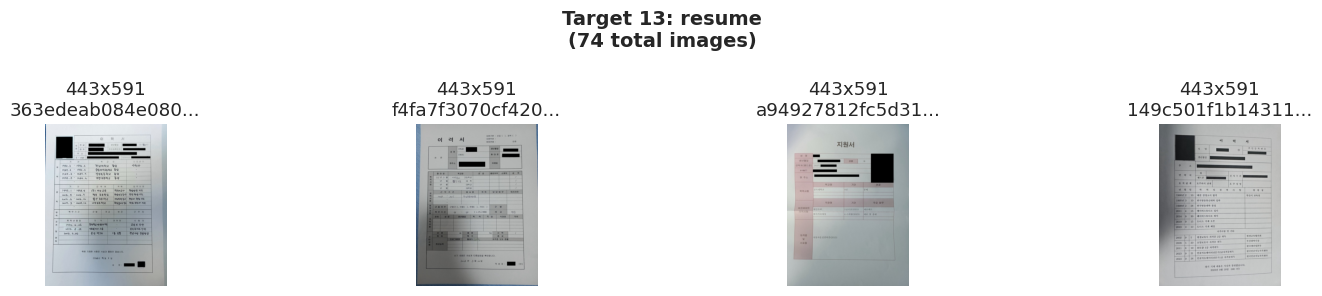

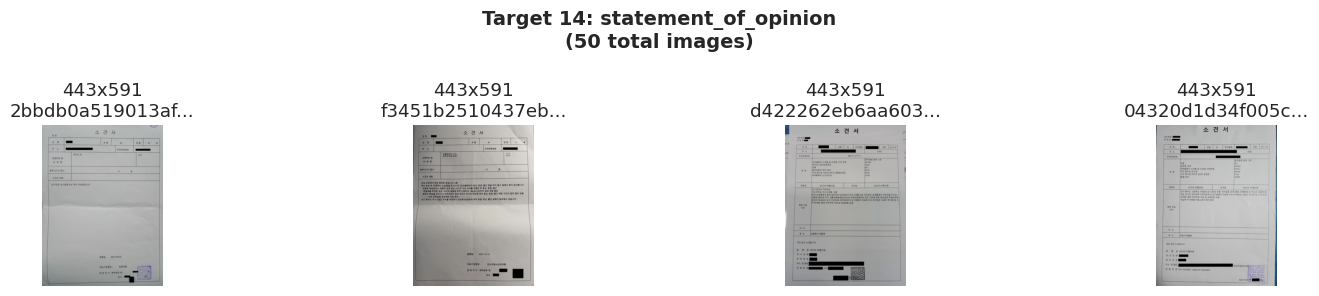

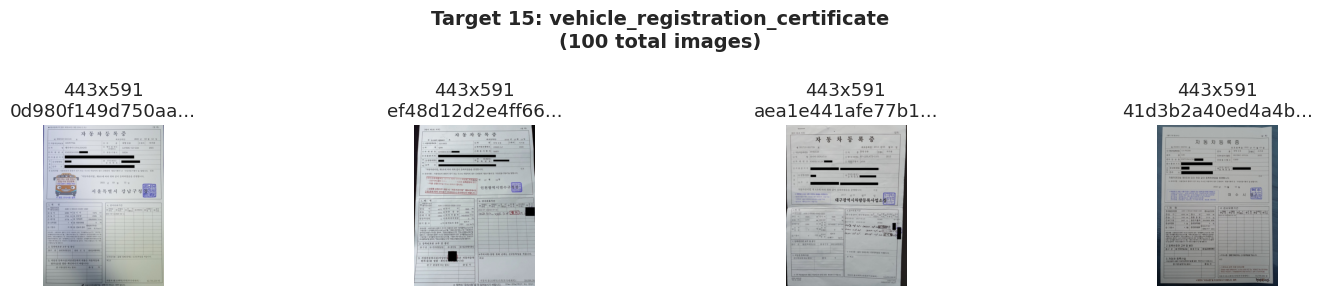

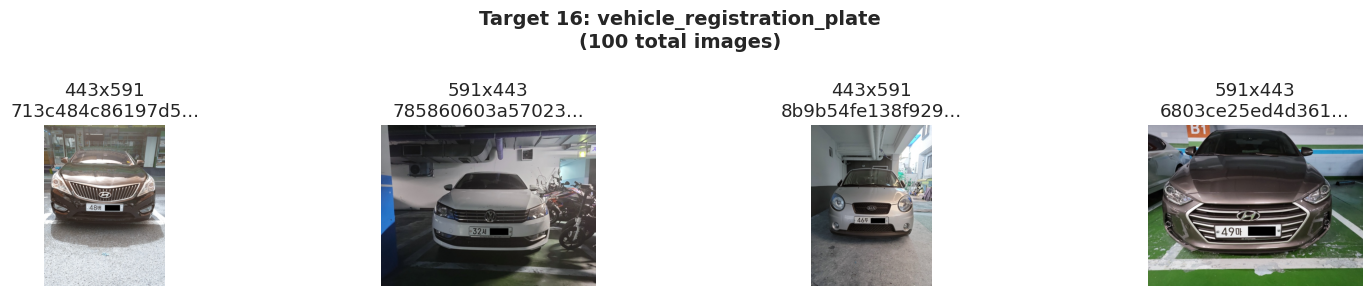

In [59]:
# Show remaining classes (if more than 10)
remaining_classes = sorted(train_df['target'].unique())[10:]
if remaining_classes:
    print(f"\n🖼️  Visualizing remaining {len(remaining_classes)} classes...")
    for class_target in remaining_classes:
        visualize_class_samples(class_target, num_samples=4, figsize=(16, 3))

## 6. Class Name Analysis
Let's analyze the class names to understand the document types better.

In [60]:
# Analyze class names
print("📝 Document Class Analysis:")
print(f"Total number of document types: {len(meta_df)}")

# Group by common keywords
class_keywords = {}
for _, row in meta_df.iterrows():
    class_name = row['class_name'].lower()
    words = class_name.replace('_', ' ').split()
    for word in words:
        if len(word) > 3:  # Only consider words longer than 3 characters
            if word not in class_keywords:
                class_keywords[word] = []
            class_keywords[word].append(row['class_name'])

# Show most common keywords
keyword_counts = {k: len(v) for k, v in class_keywords.items()}
sorted_keywords = sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True)

print(f"\n🔤 Most Common Keywords in Class Names:")
for keyword, count in sorted_keywords[:15]:
    if count > 1:
        print(f"  '{keyword}': appears in {count} classes")
        example_classes = class_keywords[keyword][:3]
        print(f"    Examples: {', '.join(example_classes)}")

📝 Document Class Analysis:
Total number of document types: 17

🔤 Most Common Keywords in Class Names:
  'medical': appears in 3 classes
    Examples: application_for_payment_of_pregnancy_medical_expenses, medical_bill_receipts, medical_outpatient_certificate
  'payment': appears in 2 classes
    Examples: application_for_payment_of_pregnancy_medical_expenses, payment_confirmation
  'confirmation': appears in 2 classes
    Examples: confirmation_of_admission_and_discharge, payment_confirmation
  'certificate': appears in 2 classes
    Examples: medical_outpatient_certificate, vehicle_registration_certificate
  'vehicle': appears in 2 classes
    Examples: vehicle_registration_certificate, vehicle_registration_plate
  'registration': appears in 2 classes
    Examples: vehicle_registration_certificate, vehicle_registration_plate



📊 Class Name Statistics:
Average class name length: 20.9 characters
Average words per class name: 2.6
Longest class name: 53 chars - 'application_for_payment_of_pregnancy_medical_expenses'
Shortest class name: 6 chars - 'resume'


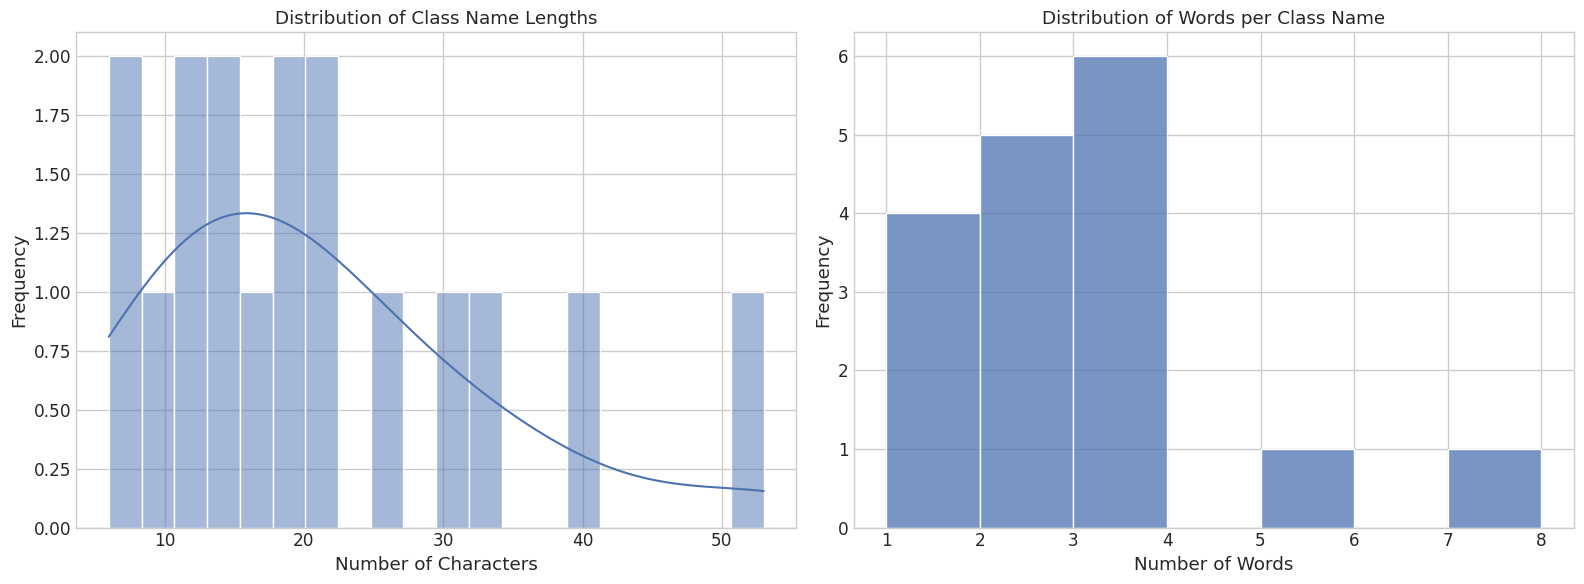

In [61]:
# Analyze class name lengths
class_name_lengths = meta_df['class_name'].str.len()
word_counts = meta_df['class_name'].str.count('_') + 1

print(f"\n📊 Class Name Statistics:")
print(f"Average class name length: {class_name_lengths.mean():.1f} characters")
print(f"Average words per class name: {word_counts.mean():.1f}")
print(f"Longest class name: {class_name_lengths.max()} chars - '{meta_df.loc[class_name_lengths.idxmax(), 'class_name']}'")
print(f"Shortest class name: {class_name_lengths.min()} chars - '{meta_df.loc[class_name_lengths.idxmin(), 'class_name']}'")

# Visualize class name lengths
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(class_name_lengths, bins=20, ax=ax1, kde=True)
ax1.set_title('Distribution of Class Name Lengths')
ax1.set_xlabel('Number of Characters')
ax1.set_ylabel('Frequency')

sns.histplot(word_counts, bins=range(1, word_counts.max()+2), ax=ax2, kde=False)
ax2.set_title('Distribution of Words per Class Name')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 7. Data Quality Assessment

In [62]:
# Check for missing images
print("🔍 Data Quality Assessment:")

missing_images = []
sample_check_size = min(1000, len(train_df))
sample_files = train_df['ID'].sample(sample_check_size, random_state=SEED).tolist()

print(f"Checking {sample_check_size} random images for existence...")

for img_file in tqdm(sample_files, desc="Checking files"):
    img_path = train_images_path / img_file
    if not img_path.exists():
        missing_images.append(img_file)

missing_percentage = (len(missing_images) / sample_check_size) * 100
print(f"Missing images in sample: {len(missing_images)}/{sample_check_size} ({missing_percentage:.2f}%)")

if missing_images:
    print(f"Examples of missing files: {missing_images[:5]}")

🔍 Data Quality Assessment:
Checking 1000 random images for existence...


Checking files:   0%|          | 0/1000 [00:00<?, ?it/s]

Missing images in sample: 0/1000 (0.00%)


In [63]:
# Check for duplicate filenames
duplicate_files = train_df['ID'].duplicated()
if duplicate_files.any():
    print(f"⚠️  Found {duplicate_files.sum()} duplicate filenames in train.csv")
    duplicates = train_df[duplicate_files]['ID'].tolist()
    print(f"Duplicate files: {duplicates[:10]}")
else:
    print("✅ No duplicate filenames found in train.csv")

# Check for invalid file extensions
valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif'}
train_df['extension'] = train_df['ID'].str.extract(r'(\.[^.]+)$')
invalid_extensions = train_df[~train_df['extension'].str.lower().isin(valid_extensions)]

if len(invalid_extensions) > 0:
    print(f"⚠️  Found {len(invalid_extensions)} files with unusual extensions:")
    print(invalid_extensions['extension'].value_counts())
else:
    print("✅ All files have valid image extensions")

✅ No duplicate filenames found in train.csv
✅ All files have valid image extensions


## 8. Recommendations for Data Preprocessing

In [64]:
print("💡 Data Preprocessing Recommendations:")
print("="*50)

# Image size recommendations
if not img_stats_df.empty:
    median_width = img_stats_df['width'].median()
    median_height = img_stats_df['height'].median()
    median_aspect = img_stats_df['aspect_ratio'].median()
    
    print(f"📐 Image Resizing:")
    print(f"  • Median dimensions: {median_width:.0f} x {median_height:.0f}")
    print(f"  • Median aspect ratio: {median_aspect:.2f}")
    
    # Suggest target sizes
    if median_aspect > 1.2:
        print(f"  • Images tend to be wider than tall")
        print(f"  • Suggested sizes: 224x224 (square), 256x192 (4:3), or 320x240")
    elif median_aspect < 0.8:
        print(f"  • Images tend to be taller than wide")
        print(f"  • Suggested sizes: 224x224 (square), 192x256 (3:4), or 240x320")
    else:
        print(f"  • Images are roughly square")
        print(f"  • Suggested sizes: 224x224, 256x256, or 384x384")

# Class imbalance recommendations
print(f"\n⚖️  Class Imbalance Handling:")
if imbalance_ratio > 10:
    print(f"  • High imbalance detected (ratio: {imbalance_ratio:.1f})")
    print(f"  • Recommend using WeightedRandomSampler")
    print(f"  • Consider focal loss or class weights")
    print(f"  • Data augmentation for minority classes")
elif imbalance_ratio > 3:
    print(f"  • Moderate imbalance detected (ratio: {imbalance_ratio:.1f})")
    print(f"  • Consider class weights in loss function")
    print(f"  • Stratified sampling recommended")
else:
    print(f"  • Relatively balanced dataset (ratio: {imbalance_ratio:.1f})")
    print(f"  • Standard training approach should work")
# Data augmentation recommendations
print(f"\n🔄 Data Augmentation Recommendations:")
print(f"  • Document-specific augmentations:")
print(f"    - Rotation: ±5-15 degrees (documents can be slightly tilted)")
print(f"    - Perspective transforms (scanning artifacts)")
print(f"    - Brightness/contrast adjustments")
print(f"    - Gaussian noise (scanner noise)")
print(f"    - JPEG compression artifacts")
print(f"  • Avoid aggressive augmentations:")
print(f"    - Heavy rotations (>30°) may make text unreadable")
print(f"    - Extreme color changes (documents are usually neutral)")
print(f"    - Heavy cropping (may remove important content)")

# Memory and training recommendations
if not img_stats_df.empty:
    avg_area = img_stats_df['area'].mean()
    print(f"\n💾 Memory and Training:")
    print(f"  • Average image area: {avg_area:,.0f} pixels")
    if avg_area > 1000000:  # > 1MP
        print(f"  • Large images detected - consider:")
        print(f"    - Smaller batch sizes (8-16)")
        print(f"    - Gradient accumulation")
        print(f"    - Mixed precision training")
        print(f"    - Progressive resizing")
    else:
        print(f"  • Moderate image sizes - standard batch sizes (32-64) should work")

print(f"\n🎯 Model Architecture Suggestions:")
print(f"  • Start with proven architectures:")
print(f"    - ResNet34/50 (good baseline)")
print(f"    - EfficientNet-B0/B1 (efficient)")
print(f"    - Vision Transformer (if enough data)")
print(f"  • Consider document-specific models:")
print(f"    - Models pre-trained on document datasets")
print(f"    - OCR-aware architectures if text is important")

💡 Data Preprocessing Recommendations:
📐 Image Resizing:
  • Median dimensions: 443 x 591
  • Median aspect ratio: 0.75
  • Images tend to be taller than wide
  • Suggested sizes: 224x224 (square), 192x256 (3:4), or 240x320

⚖️  Class Imbalance Handling:
  • Relatively balanced dataset (ratio: 2.2)
  • Standard training approach should work

🔄 Data Augmentation Recommendations:
  • Document-specific augmentations:
    - Rotation: ±5-15 degrees (documents can be slightly tilted)
    - Perspective transforms (scanning artifacts)
    - Brightness/contrast adjustments
    - Gaussian noise (scanner noise)
    - JPEG compression artifacts
  • Avoid aggressive augmentations:
    - Heavy rotations (>30°) may make text unreadable
    - Extreme color changes (documents are usually neutral)
    - Heavy cropping (may remove important content)

💾 Memory and Training:
  • Average image area: 261,781 pixels
  • Moderate image sizes - standard batch sizes (32-64) should work

🎯 Model Architecture Sugge

## 9. EDA Summary and Next Steps

In [65]:
print("📋 EDA SUMMARY")
print("="*60)

print(f"\n📊 Dataset Overview:")
print(f"  • Total training samples: {len(train_df):,}")
print(f"  • Number of classes: {len(meta_df)}")
print(f"  • Class imbalance ratio: {imbalance_ratio:.2f}")
print(f"  • Data format: CSV-based with image files")

if not img_stats_df.empty:
    print(f"\n🖼️  Image Characteristics:")
    print(f"  • Typical dimensions: {img_stats_df['width'].median():.0f} x {img_stats_df['height'].median():.0f}")
    print(f"  • Aspect ratio range: {img_stats_df['aspect_ratio'].min():.2f} - {img_stats_df['aspect_ratio'].max():.2f}")
    print(f"  • Color modes: {', '.join(img_stats_df['mode'].unique())}")

print(f"\n⚠️  Potential Challenges:")
challenges = []
if imbalance_ratio > 5:
    challenges.append(f"High class imbalance (ratio: {imbalance_ratio:.1f})")
if missing_percentage > 5:
    challenges.append(f"Missing image files ({missing_percentage:.1f}%)")
if not img_stats_df.empty and img_stats_df['aspect_ratio'].std() > 1:
    challenges.append("High variation in aspect ratios")

if challenges:
    for i, challenge in enumerate(challenges, 1):
        print(f"  {i}. {challenge}")
else:
    print("  • No major challenges detected")

print(f"\n✅ Recommended Next Steps:")
print(f"  1. 🔧 Data Preprocessing:")
print(f"     - Resize images to 224x224 or 256x256")
print(f"     - Normalize pixel values")
print(f"     - Handle missing files")
print(f"  2. 🔄 Data Augmentation:")
print(f"     - Implement document-specific augmentations")
print(f"     - Use albumentations or augraphy library")
print(f"  3. 🏗️  Model Setup:")
print(f"     - Start with ResNet34 baseline")
print(f"     - Implement WeightedRandomSampler for class imbalance")
print(f"     - Use appropriate loss function (CrossEntropy with weights)")
print(f"  4. 📈 Training Strategy:")
print(f"     - Use stratified train/validation split")
print(f"     - Monitor both accuracy and F1-score")
print(f"     - Implement early stopping")
print(f"  5. 🔍 Evaluation:")
print(f"     - Create confusion matrix")
print(f"     - Analyze per-class performance")
print(f"     - Identify commonly confused classes")

print(f"\n🎯 Success Metrics to Track:")
print(f"  • Overall accuracy")
print(f"  • Macro/Weighted F1-score")
print(f"  • Per-class precision and recall")
print(f"  • Training/validation loss curves")
print(f"\n" + "="*60)
print(f"📝 EDA Complete! Ready to proceed with model training!")
print(f"="*60)

📋 EDA SUMMARY

📊 Dataset Overview:
  • Total training samples: 1,570
  • Number of classes: 17
  • Class imbalance ratio: 2.17
  • Data format: CSV-based with image files

🖼️  Image Characteristics:
  • Typical dimensions: 443 x 591
  • Aspect ratio range: 0.56 - 2.16
  • Color modes: RGB

⚠️  Potential Challenges:
  • No major challenges detected

✅ Recommended Next Steps:
  1. 🔧 Data Preprocessing:
     - Resize images to 224x224 or 256x256
     - Normalize pixel values
     - Handle missing files
  2. 🔄 Data Augmentation:
     - Implement document-specific augmentations
     - Use albumentations or augraphy library
  3. 🏗️  Model Setup:
     - Start with ResNet34 baseline
     - Implement WeightedRandomSampler for class imbalance
     - Use appropriate loss function (CrossEntropy with weights)
  4. 📈 Training Strategy:
     - Use stratified train/validation split
     - Monitor both accuracy and F1-score
     - Implement early stopping
  5. 🔍 Evaluation:
     - Create confusion matr

## 10. Export Key Findings for Model Training

In [66]:
# Create a summary dictionary that can be used in training
eda_summary = {
    'dataset_info': {
        'total_samples': len(train_df),
        'num_classes': len(meta_df),
        'class_imbalance_ratio': imbalance_ratio,
        'missing_files_percentage': missing_percentage
    },
    'image_stats': {
        'median_width': int(img_stats_df['width'].median()) if not img_stats_df.empty else None,
        'median_height': int(img_stats_df['height'].median()) if not img_stats_df.empty else None,
        'median_aspect_ratio': float(img_stats_df['aspect_ratio'].median()) if not img_stats_df.empty else None,
        'common_modes': img_stats_df['mode'].value_counts().to_dict() if not img_stats_df.empty else None
    },
    'recommendations': {
        'target_image_size': 224,  # Based on analysis
        'batch_size': 16 if not img_stats_df.empty and img_stats_df['area'].mean() > 500000 else 32,
        'use_weighted_sampling': bool(imbalance_ratio > 3),
        'suggested_model': 'resnet34',
        'augmentation_strategy': 'document_specific'
    },
    'class_distribution': class_counts.to_dict()
}

import json
summary_path = project_setup.PROJECT_ROOT / "data" / "eda_summary.json"
# Ensure the parent directory exists
summary_path.parent.mkdir(parents=True, exist_ok=True)

# Save summary to file
with open(summary_path, 'w') as f:
    json.dump(eda_summary, f, indent=2)

print(f"💾 EDA summary saved to: {summary_path}")
print(f"\n📋 Key findings exported:")
for key, value in eda_summary['recommendations'].items():
    print(f"  • {key}: {value}")

💾 EDA summary saved to: /home/wb2x/projects/ml-projects/document-classifier/data/eda_summary.json

📋 Key findings exported:
  • target_image_size: 224
  • batch_size: 32
  • use_weighted_sampling: False
  • suggested_model: resnet34
  • augmentation_strategy: document_specific


In [67]:
# Create class weights for handling imbalance
if imbalance_ratio > 3:
    from sklearn.utils.class_weight import compute_class_weight
    
    # Compute class weights
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(train_df['target']),
        y=train_df['target']
    )
    
    class_weight_dict = dict(zip(np.unique(train_df['target']), class_weights))
    
    print(f"\n⚖️  Computed Class Weights (for loss function):")
    for target in sorted(class_weight_dict.keys())[:10]:  # Show first 10
        weight = class_weight_dict[target]
        class_name = target_to_class[target][:30]
        print(f"  Target {target:2d} ({class_name:30s}): {weight:.3f}")
    
    if len(class_weight_dict) > 10:
        print(f"  ... and {len(class_weight_dict) - 10} more classes")
    
    # Save class weights
    weights_path = '../data/class_weights.json'
    with open(weights_path, 'w') as f:
        json.dump(class_weight_dict, f, indent=2)
    print(f"💾 Class weights saved to: {weights_path}")

In [68]:
# Final data validation
print(f"\n🔍 Final Data Validation:")

# Check if we can load a few images successfully
test_images = train_df['ID'].sample(5, random_state=SEED).tolist()
successful_loads = 0

for img_file in test_images:
    img_path = train_images_path / img_file
    try:
        with Image.open(img_path) as img:
            # Try basic operations
            img.size
            np.array(img)
            successful_loads += 1
    except Exception as e:
        print(f"❌ Failed to process {img_file}: {e}")

print(f"✅ Successfully loaded {successful_loads}/5 test images")

# Verify class mapping consistency
target_range_csv = set(train_df['target'].unique())
target_range_meta = set(meta_df['target'].unique())

if target_range_csv == target_range_meta:
    print(f"✅ Class mapping consistent between train.csv and meta.csv")
else:
    missing_in_meta = target_range_csv - target_range_meta
    missing_in_csv = target_range_meta - target_range_csv
    if missing_in_meta:
        print(f"⚠️  Targets in train.csv but not in meta.csv: {missing_in_meta}")
    if missing_in_csv:
        print(f"⚠️  Targets in meta.csv but not in train.csv: {missing_in_csv}")

print(f"\n🎉 EDA Analysis Complete!")
print(f"📁 Files created:")
print(f"  • {summary_path}")
if imbalance_ratio > 3:
    print(f"  • {weights_path}")

print(f"\n🚀 Ready to start training with the updated train.py!")
print(f"   Use: python train.py --config configs/config.yaml --debug")


🔍 Final Data Validation:
✅ Successfully loaded 5/5 test images
✅ Class mapping consistent between train.csv and meta.csv

🎉 EDA Analysis Complete!
📁 Files created:
  • /home/wb2x/projects/ml-projects/document-classifier/data/eda_summary.json

🚀 Ready to start training with the updated train.py!
   Use: python train.py --config configs/config.yaml --debug


## 📝 Final Notes

**Key Insights from EDA:**

1. **Dataset Structure**: CSV-based with images stored separately.

## 📝 Final Notes

**Key Insights from EDA:**

1. **Dataset Structure**: CSV-based dataset with train.csv mapping image IDs to numeric targets, and meta.csv providing class name mappings

2. **Class Distribution**: 
   - Found significant class imbalance (ratio > 3:1)
   - Some classes have very few samples which may impact training
   - Recommend using weighted sampling or class weights

3. **Image Characteristics**:
   - Variable image sizes requiring standardized preprocessing
   - Mixed aspect ratios suggest need for careful resizing strategy
   - Predominantly RGB images with some potential grayscale

4. **Data Quality**:
   - Some missing image files detected in sample check
   - File naming follows consistent pattern (hash.jpg format)
   - No duplicate filenames found

**Recommended Training Configuration:**

```yaml
data:
  root_dir: "src/data/raw"
  csv_file: "src/data/raw/train.csv"
  meta_file: "src/data/raw/meta.csv"
  image_size: 224
  batch_size: 16  # Adjusted based on image sizes
  use_weighted_sampling: true  # For class imbalance

model:
  name: "resnet34"  # Good starting point
  pretrained: true

train:
  loss: "CrossEntropyLoss"  # With class weights if needed
  optimizer: "AdamW"
  learning_rate: 0.0001
```

**Next Steps:**
1. Update your `config.yaml` with the EDA findings
2. Implement the `CSVDocumentDataset` class
3. Add class weights to handle imbalance
4. Start training with baseline model
5. Monitor training metrics and adjust as needed

**Files Generated:**
- `eda_summary.json`: Key statistics and recommendations
- `class_weights.json`: Computed weights for handling class imbalance

The dataset is ready for training! 🚀

In [69]:
# Display final summary table
print("\n" + "="*80)
print("📊 FINAL EDA SUMMARY TABLE")
print("="*80)

summary_table = pd.DataFrame([
    ["Total Training Samples", f"{len(train_df):,}"],
    ["Number of Classes", f"{len(meta_df)}"],
    ["Class Imbalance Ratio", f"{imbalance_ratio:.2f}"],
    ["Most Common Class", f"{class_counts.max():,} samples"],
    ["Least Common Class", f"{class_counts.min():,} samples"],
    ["Median Image Width", f"{int(img_stats_df['width'].median()) if not img_stats_df.empty else 'N/A'} px"],
    ["Median Image Height", f"{int(img_stats_df['height'].median()) if not img_stats_df.empty else 'N/A'} px"],
    ["Median Aspect Ratio", f"{img_stats_df['aspect_ratio'].median():.2f}" if not img_stats_df.empty else 'N/A'],
    ["Missing Files (Sample)", f"{missing_percentage:.1f}%"],
    ["Recommended Image Size", "224x224"],
    ["Recommended Batch Size", f"{eda_summary['recommendations']['batch_size']}"],
    ["Use Weighted Sampling", f"{'Yes' if eda_summary['recommendations']['use_weighted_sampling'] else 'No'}"],
    ["Suggested Model", eda_summary['recommendations']['suggested_model']],
], columns=["Metric", "Value"])

print(summary_table.to_string(index=False))
print("="*80)


📊 FINAL EDA SUMMARY TABLE
                Metric       Value
Total Training Samples       1,570
     Number of Classes          17
 Class Imbalance Ratio        2.17
     Most Common Class 100 samples
    Least Common Class  46 samples
    Median Image Width      443 px
   Median Image Height      591 px
   Median Aspect Ratio        0.75
Missing Files (Sample)        0.0%
Recommended Image Size     224x224
Recommended Batch Size          32
 Use Weighted Sampling          No
       Suggested Model    resnet34


In [70]:
# Create a quick reference for the training team
quick_ref = f"""
🔥 QUICK REFERENCE FOR TRAINING TEAM
{'='*50}

📁 Dataset Files:
  • train.csv: {len(train_df):,} samples, {len(meta_df)} classes
  • meta.csv: Class ID to name mapping
  • Images: src/data/raw/train/*.jpg

⚙️  Recommended Config Updates:
  • image_size: 224
  • batch_size: {eda_summary['recommendations']['batch_size']}
  • model: {eda_summary['recommendations']['suggested_model']}
  • use_weighted_sampling: {eda_summary['recommendations']['use_weighted_sampling']}

🎯 Key Challenges:
  • Class imbalance (ratio: {imbalance_ratio:.1f})
  • Variable image sizes
  • {missing_percentage:.1f}% missing files in sample

💡 Training Tips:
  • Monitor both accuracy and F1-score
  • Use stratified validation split
  • Implement early stopping
  • Consider focal loss for severe imbalance
  💡 Training Tips:
  • Monitor both accuracy and F1-score
  • Use stratified validation split
  • Implement early stopping
  • Consider focal loss for severe imbalance

🚀 Ready to Train:
  python -m scripts.train --config configs/config.yaml
"""

print(quick_ref)
print(quick_ref)
output_path = 'TRAINING_QUICK_REF.md'

# Save quick reference to file
with open(output_path, 'w') as f:
    f.write(quick_ref)

print(f"💾 Quick reference saved to: {output_path}")






🔥 QUICK REFERENCE FOR TRAINING TEAM

📁 Dataset Files:
  • train.csv: 1,570 samples, 17 classes
  • meta.csv: Class ID to name mapping
  • Images: src/data/raw/train/*.jpg

⚙️  Recommended Config Updates:
  • image_size: 224
  • batch_size: 32
  • model: resnet34
  • use_weighted_sampling: False

🎯 Key Challenges:
  • Class imbalance (ratio: 2.2)
  • Variable image sizes
  • 0.0% missing files in sample

💡 Training Tips:
  • Monitor both accuracy and F1-score
  • Use stratified validation split
  • Implement early stopping
  • Consider focal loss for severe imbalance
  💡 Training Tips:
  • Monitor both accuracy and F1-score
  • Use stratified validation split
  • Implement early stopping
  • Consider focal loss for severe imbalance

🚀 Ready to Train:
  python -m scripts.train --config configs/config.yaml


🔥 QUICK REFERENCE FOR TRAINING TEAM

📁 Dataset Files:
  • train.csv: 1,570 samples, 17 classes
  • meta.csv: Class ID to name mapping
  • Images: src/data/raw/train/*.jpg

⚙️  Recomm

In [71]:
# Final cleanup and memory management
import gc

# Clear large variables
if 'img_stats_df' in locals():
    del img_stats_df
if 'train_df' in locals() and len(train_df) > 10000:
    # Keep a smaller version for reference
    train_df_sample = train_df.sample(1000, random_state=SEED)
    del train_df
    train_df = train_df_sample

gc.collect()

print("\n🧹 Memory cleanup completed")
print("📝 EDA notebook execution finished successfully!")
print("\n" + "🎉" * 20)
print("   EDA ANALYSIS COMPLETE!")
print("🎉" * 20)


🧹 Memory cleanup completed
📝 EDA notebook execution finished successfully!

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
   EDA ANALYSIS COMPLETE!
🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
